# Import Data & Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
from ast import literal_eval
import konlpy
from collections import Counter
import time
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
df_whole=pd.read_json('amore_data_detected_bert.json')
df_whole['review_split_string']=df_whole['review_split'].copy()
df_whole['review_split']=df_whole['review_split_string'].apply(literal_eval)
print(df_whole.shape)

(50183, 50)


In [4]:
df_whole['name']=df_whole[['brand','big_category','prod_nm']].agg('#'.join, axis=1)
df_whole['name_sub']=df_whole[['brand','big_category']].agg('#'.join, axis=1)

In [5]:
df_whole.head(2)

,A용량,A민감성,A향기,A커버력,A지속력,A피부톤,A보습감,A향,A사용감,A발림성,...,트러블,표현력,품질,향기,효과,휴대성,mask,review_split_string,name,name_sub
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,"[True, False, False]","['바디워시 쓰고 반해서 핸드워시도 사게 됬어요', '바디워시와 같은향이라 그런지 ...",sulhwasoo#catE#핸드워시 백은향 300ml,sulhwasoo#catE
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,"[True, False, False]",['선물하기에 너무 좋아용 사실 내돈주고 사기엔 아깝구 선물 받은 좋은 아이템 ㅎㅎ...,sulhwasoo#catE#핸드워시 백은향 300ml,sulhwasoo#catE


# Functions

In [6]:
def S1_number_func(x):
    return(sum([len(x[i].split(' ')) for i in range(len(x))]))

def S1_duplicate_func(x):
    return(len(set(x))/len(x))
    
def NVA(x):    
    total_words=[]
    for i, document in enumerate(list(set(x))):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): 
            if word[1] in ['Noun', 'Verb', 'Adjective']: 
                clean_words.append(word[0])
        total_words.append(clean_words)
    result = []
    for x in total_words:
        result.extend(x)
    return result


def S1_diversity_func(NVA):  
    return(len(set(NVA))/len(NVA))
    


def s1_recency_func(x,date):
    return((date-x.date()).days)

def S1_recency_func(x,max_date,window):
    """
    max=50 ( 50,49,,...1 )
    ----------------------------------------
    50,49,48,47,46 .... (max-0)~(max-window+1)
    49,48,47,46,45 .... (max-1)~(max-window+0)
    48,47,46,45,44 .... (max-2)~(max-window-1)
    ...
    5,4,3,2,1 ...,,,,,,. (max-45)~(max-window-44)
    ----------------------------------------
    max-45가 window가 될 때 까지
    """
    lower = max_date
    upper = max_date-window+1
    lower_sign=(x<=lower)
    upper_sign=(x>=upper)
    sign=lower_sign*upper_sign
    return sign

def s1_recency_list_func(prod_nm):
    tmp=S1_recency[S1_recency['prod_nm']==prod_nm]
    MA_list=[]
    for i in date_range:
        window_count = len(tmp['s1_recency'][tmp['s1_recency'].apply((lambda x: S1_recency_func(x,max_date-i,recency_window)))>0])
        window_count_mean = window_count/recency_window
        MA_list.append(window_count_mean)
    return MA_list

# SBS

각 요소는 0~1사이 값을 가지도록 구성한다

## 날짜 범위 설정

- 점수 계산 날짜 : (x)일
- 점수 계산 대상 날짜 : (x-14)일~ (x)일

In [7]:
def get_current_Kdays(df,current_Y,current_M,current_D,K=14):
    eval_date = datetime.date(current_Y,current_M,current_D)
    df['recency']=df['date'].apply((lambda x: s1_recency_func(x,eval_date)))
    return df[df['recency']<K]

In [72]:
df = get_current_Kdays(df_whole,2021,7,31,K=60)

In [73]:
df.shape

(4239, 53)

In [74]:
brand=list(set(df['brand']))
prod_name=list(set(df['name']))
prod_name_sub=list(set(df['name_sub']))

## (score 1) Prevalence

In [75]:
score1 = df['name'].value_counts()
#score1 = score1/score1.max()

In [76]:
df

,A용량,A민감성,A향기,A커버력,A지속력,A피부톤,A보습감,A향,A사용감,A발림성,...,표현력,품질,향기,효과,휴대성,mask,review_split_string,name,name_sub,recency
22,0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,"[True, True, False]","['제품이 좋아서 항상 사용하고 있습니다.', '커버력도 좋고 지속력도 좋아요']",sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,sulhwasoo#catB,17
23,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,"[True, False, True]","['톤 21호 잘맞아요', '촉촉해서 커버는 아쉽지만 건성피부에 잘 맞는것 같아요'...",sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,sulhwasoo#catB,20
24,0,0,0,0,0,1,0,0,0,0,...,1,1,0,0,0,"[True, True, False]","['출시된 직후 10통 정도 사용할 만큼 만족도고좋은 제품이예요.', '솔직히 파데...",sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,sulhwasoo#catB,30
25,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,"[True, False, False]","['특유의 매화향이 나서 쿠션 두들길때마다 기분좋게 해주는 쿠션입니다.', '다소 ...",sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,sulhwasoo#catB,41
26,0,0,0,1,1,1,0,0,0,0,...,1,1,0,1,0,"[True, True, False]",['탄력이 없는 피부라 화장이 들뜬 느낌이 드는데 이제품은 커버력이 뛰어나 만족합니다'],sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,sulhwasoo#catB,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48459,0,1,0,0,0,0,1,1,0,0,...,0,0,0,1,0,"[True, True, False]","['얼굴 열감때문에 진정용도로 마스크팩을 자주 쓰는 편이라 아주 잘 사용했습니다',...",hanyul#catA#자연을 닮은 시트마스크 1매,hanyul#catA,57
48460,0,1,0,0,0,0,1,1,0,0,...,0,0,0,1,0,"[False, True, False]","['촉촉한 워터 타입이 에센스가 넉넉하게 들어 있습니다', '피부에 흡수가 잘 되는...",hanyul#catA#자연을 닮은 시트마스크 1매,hanyul#catA,57
48461,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,"[False, True, False]","['제품은 빠르고 이상없이 잘 도착했습니다.', '항상 쓰던 제품이라 할인을 해서 ...",hanyul#catA#자연을 닮은 시트마스크 1매,hanyul#catA,58
48462,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,"[False, True, False]","['제품은 빠르고 이상없이 잘 도착했습니다.', '항상 쓰던 제품이라 할인을 해서 ...",hanyul#catA#자연을 닮은 시트마스크 1매,hanyul#catA,58


In [47]:
#f['name'].apply(lambda x:x.replace({'ml':''}))

In [70]:
df['name']=df['name'].str.replace('ml', '')
df['name']=df['name'].str.replace('g', '')
df['name']=df['name'].str.replace('\d+', 'kk').str.replace('\d+', 'kk')
df['name']=df['name'].str.replace('kk매', '')
df['name']=df['name'].str.replace('kk호', '')
df['name']=df['name'].str.replace('kk', '')

C:\Users\LSH\AppData\Local\Temp/ipykernel_4804/2492712262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name']=df['name'].str.replace('ml', '')
C:\Users\LSH\AppData\Local\Temp/ipykernel_4804/2492712262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name']=df['name'].str.replace('g', '')
C:\Users\LSH\AppData\Local\Temp/ipykernel_4804/2492712262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [62]:
min_review_thres=1

In [69]:
df['name']

22       sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF+/PA+++ 
23       sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF+/PA+++ 
24       sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF+/PA+++ 
25       sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF+/PA+++ 
26       sulhwasoo#catB#[리필] 퍼펙팅 쿠션 SPF+/PA+++ 
                          ...                  
48459                 hanyul#catA#자연을 닮은 시트마스크 
48460                 hanyul#catA#자연을 닮은 시트마스크 
48461                 hanyul#catA#자연을 닮은 시트마스크 
48462                 hanyul#catA#자연을 닮은 시트마스크 
48463                 hanyul#catA#자연을 닮은 시트마스크 
Name: name, Length: 4239, dtype: object

In [67]:
len(set(df['name']))

359

In [63]:
np.mean(score1>min_review_thres)

0.8032345013477089

<AxesSubplot:title={'center':'[score 1] Prevalence'}, ylabel='Frequency'>

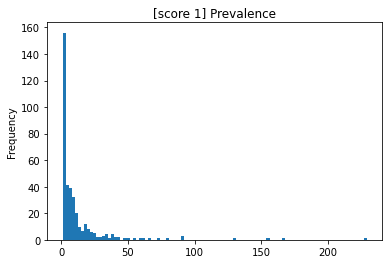

In [19]:
score1.plot(kind='hist',bins=100,title='[score 1] Prevalence')

In [20]:
score1.mean()

11.425876010781671

## (score 2) Diversity

- nva : Noun + Verb + Adjective
- 소요 시간 : **0.04초/1개 리뷰**

In [73]:
nva=df['review_split'].apply(NVA)

In [74]:
df['diversity'] = nva.apply(S1_diversity_func)

<ipython-input-74-0a59c65ad644>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diversity'] = nva.apply(S1_diversity_func)


In [75]:
score2=df.groupby('name').mean()['diversity']

In [76]:
score2

name
amore#catA#[리필] 모이스춰 플럼핑 듀이 미스트 100ml                  0.886282
amore#catA#더 에센셜 크림 플루이드 90ml                          0.875850
amore#catA#라인에이징 코렉터 30ml                              1.000000
amore#catA#모이스춰 플럼핑 넥타 크림 30ml                         0.795139
amore#catA#모이스춰 플럼핑 넥타 크림 50ml                         0.898349
                                                         ...   
sulhwasoo#catB#[설화수x피카소] 퍼펙팅파운데이션 17N + 산수화 브러쉬 세트     0.774194
sulhwasoo#catB#[설화수x피카소] 퍼펙팅파운데이션 21N + 산수화 브러쉬 세트     0.827891
sulhwasoo#catB#퍼펙팅 쿠션 SPF50+/PA+++ 15g*2(본품+리필)        0.779957
sulhwasoo#catE#트래블키트 백은향 50ml*4                        0.909091
sulhwasoo#catE#핸드크림 백은향 40ml                           0.931034
Name: diversity, Length: 248, dtype: float64

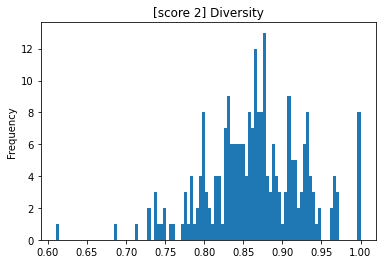

In [77]:
score2.plot(kind='hist',bins=100,title='[score 2] Diversity')

## (score 3) Connectivity

- connectivity의 network 구성에는 너무 많은 연산량이 소요된다.
- 많이 등장한 top K word만을 대상으로 네트워크를 구성한다
- (주의) 제품명 텍스트 (prod_name)은 반드시 포함해야!
- 모든 "review text"앞에 "브랜드#대제품군#제품명" 붙이기

In [98]:
def top_K_words(nva,prod_name_sub,K,node='brand'):
    
    assert node in ['brand','brand+big','brand+big+prd']
    top_K=[]
    
    if node=='brand':
        tmp=list(df['brand'])
        top_K.extend(list(set(df['brand'])))
    elif node=='brand+big':
        tmp=list(df['name_sub'])
        top_K.extend(list(set(df['name_sub'])))
    else:
        tmp=list(df['name'])
        top_K.extend(list(set(df['name'])))
    
    nva_list=list(nva)
    for i in range(len(nva_list)):
        nva_list[i]=[tmp[i]]+nva_list[i]

    concat_list = np.concatenate(nva_list)

        
    cnt = Counter(concat_list)
    list_sorted = sorted(list(cnt.items()), key=lambda x: [-x[1], x[0]])
    nva_topK = []
    
    for i in range(10*K): 
        top_K.append(list_sorted[i][0])
    print(len(top_K))
    top_K = [word for word in top_K if len(word)>1]
    print(len(top_K))
    top_K = [word for word in top_K if ((len(word)!=2)&(word[1]!='다'))]
    print(len(top_K))
    top_K = top_K[:K]
    print(len(top_K))
    for idx in range(len(nva.index)):
        nva_topK.append([word for word in nva_list[idx] if word in top_K])

    before=len(np.concatenate(nva.values))
    after=len(np.concatenate(nva_topK))
    print(np.round(after/before,3)*100,'% 만큼의 단어 생존')
    
    return nva_topK

In [99]:
def get_coocmat(nva_topK):
    u = (pd.get_dummies(pd.DataFrame(nva_topK), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

    cooc_mat = u.T.dot(u)
    cooc_mat.values[(np.r_[:len(cooc_mat)], ) * 2] = 0
    return cooc_mat
    

In [100]:
def connectivity_from_cooc(coocurence_mat):
    cooc_mat = coocurence_mat.copy()
    print('shape of coocurrence matrix :',cooc_mat.shape)
    time1 = time.time()
    conn = cooc_mat.stack()
    conn=conn.rename_axis(('source','target')).reset_index(name='weight')
    G = nx.from_pandas_edgelist(conn,edge_attr=True)
    time2 = time.time()
    print('Constructing Graph took {} secs'.format(time2-time1))
    for u,v,data in G.edges(data=True):
        if 'weight' in data and data['weight']!=0:
            data['inverse']=1/data['weight']
        else:
            data['inverse']=1
    connectivity = nx.betweenness_centrality(G,normalized=False,weight='inverse',endpoints =True)
    time3 = time.time()
    print('Calculating Connectivity took {} secs'.format(time3-time2))
    return connectivity

### brand

In [101]:
#connectivity_tmp

In [102]:
tt=[]
for i in nva_topK:
    for j in i:
        tt.append(j)

In [103]:
len(set(tt))

78

In [104]:
nva

95       [저, 몇번, 사용, 해보다, 어마, 니, 왜, 계속, 사용, 하다, 알다, 같다,...
206      [좋다, 사용, 하다, 되다, 또, 구입, 하다, 의향, 있다, 여름, 피부, 건조...
207      [향, 윤조, 에센스, 자음, 생, 합치다, 은은하다, 지속, 되다, 것, 같다, ...
278      [마스크, 착용, 지치다, 나, 피부, 촉촉하다, 피부, 자극, 사용, 하다, 좋다...
279      [어른, 쓸다, 설화수, 화장품, 없다, 같다, 담, 진설, 라인, 사드, 리, 싶...
                               ...                        
48291    [종류, 별로, 구매, 하다, 보다, 구매, 하다, 보호, 적히다, 율, 마스크, ...
48292    [율, 제품, 마스크, 팩, 좋다, 것, 같다, 시트, 얇다, 피부, 밀착, 자다,...
48293    [마스크, 팩, 시트, 일단, 정, 도톰하다, 순하다, 촉촉하다, 쑥, 마스크, 팩...
48294    [마스크, 팩, 꾸준하다, 사용, 하다, 더욱, 효과, 여서, 팩, 계속, 사용, ...
48295    [애정, 하다, 팩, 보습, 쫀쫀하, 되다, 제품, 여름, 겨울, 하다, 더, 좋다...
Name: review_split, Length: 1036, dtype: object

In [105]:
# ['brand','brand+big','brand+big+prd']
nva_topK = top_K_words(nva,list(set(df['brand'])),K=100,node='brand')
cooc_mat=get_coocmat(nva_topK)
connectivity_tmp = connectivity_from_cooc(cooc_mat)

tmp=[]
for b in brand:
    tmp.append(connectivity_tmp[b])
connectivity=tmp/max(np.array(tmp))

score3=dict(zip(brand,connectivity))

1008
839
293
100
15.7 % 만큼의 단어 생존
shape of coocurrence matrix : (92, 92)
Constructing Graph took 0.026525259017944336 secs
Calculating Connectivity took 0.4490964412689209 secs


In [106]:
cooc_mat

,amore,hanyul,hera,iope,laneige,mamonde,primera,sulhwasoo,가볍다,간편하다,...,파운데이션,패키지,편하다,필요하다,해보다,해봤다,해주다,화사하다,화장품,확실하다
amore,0,0,0,0,0,0,0,0,5,0,...,0,0,1,1,0,1,1,0,1,2
hanyul,0,0,0,0,0,0,0,0,10,0,...,1,6,5,5,16,9,10,1,7,8
hera,0,0,0,0,0,0,0,0,27,6,...,10,9,11,3,22,20,12,17,4,5
iope,0,0,0,0,0,0,0,0,5,2,...,1,0,5,1,6,3,5,0,3,5
laneige,0,0,0,0,0,0,0,0,16,2,...,25,4,10,4,12,8,13,13,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
해봤다,1,9,20,3,8,12,5,2,11,3,...,0,0,5,1,13,0,1,9,2,3
해주다,1,10,12,5,13,9,5,6,9,4,...,4,1,1,0,6,1,0,1,2,6
화사하다,0,1,17,0,13,1,0,6,12,0,...,8,0,1,2,2,9,1,0,2,2
화장품,1,7,4,3,3,9,4,3,3,0,...,0,0,5,1,4,2,2,2,0,3


In [62]:
score3=dict(zip(brand,connectivity))

### brand+big

In [63]:
# ['brand','brand+big','brand+big+prd']
nva_topK_ = top_K_words(nva,list(set(df['brand'])),K=300,node='brand+big')
cooc_mat_=get_coocmat(nva_topK_)
connectivity_tmp_ = connectivity_from_cooc(cooc_mat_)


tmp=[]
for b in cooc_mat_.columns[cooc_mat_.columns.str.contains('cat')]:
    tmp.append(connectivity_tmp_[b])
connectivity_=tmp/max(np.array(tmp))

score3_=dict(zip(cooc_mat_.columns[cooc_mat_.columns.str.contains('cat')],connectivity_))

18.4 % 만큼의 단어 생존
shape of coocurrence matrix : (181, 181)
Constructing Graph took 0.0847468376159668 secs
Calculating Connectivity took 3.9253315925598145 secs


# 계산하기

## brand

In [86]:
temp=pd.DataFrame(score1).reset_index()
temp['brand'] = temp['index'].apply(lambda x:x.split('#')[0])
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['name']=temp3['name']*temp3['weight']
temp4=temp3.groupby('brand').sum()['name']
Score1=temp4/temp4.max()
Score1

brand
amore        0.350334
hanyul       1.000000
hera         0.780329
iope         0.456606
laneige      0.512405
mamonde      0.717716
primera      0.735107
sulhwasoo    0.425680
Name: name, dtype: float64

In [87]:
temp=pd.DataFrame(score2).reset_index()
temp['brand'] = temp['name'].apply(lambda x:x.split('#')[0])
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['diversity']=temp3['diversity']*temp3['weight']
temp4=temp3.groupby('brand').sum()['diversity']
Score2=temp4/temp4.max()
Score2

brand
amore        0.996875
hanyul       0.966692
hera         1.000000
iope         0.991338
laneige      0.970120
mamonde      0.964541
primera      0.990932
sulhwasoo    0.988824
Name: diversity, dtype: float64

In [88]:
Score3=pd.Series(score3)

In [89]:
sbs=pd.concat([Score1,Score2,Score3],axis=1)
sbs.columns=['P','D','C']

In [91]:
sbs.to_csv('sbs.csv')

## brand + big

In [92]:
temp=pd.DataFrame(score1).reset_index()
temp['brand'] = temp['index'].apply(lambda x:'#'.join(x.split('#')[0:2]))
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['name']=temp3['name']*temp3['weight']
temp4=temp3.groupby('brand').sum()['name']
Score1=temp4/temp4.max()
Score1

brand
amore#catA        0.207500
amore#catB        0.160000
hanyul#catA       0.592045
hanyul#catB       0.100000
hanyul#catC       0.600000
hanyul#catE       0.416667
hera#catA         0.335455
hera#catB         0.455556
hera#catC         0.651724
hera#catD         0.189474
iope#catA         0.260317
iope#catB         0.100000
iope#catE         1.000000
laneige#catA      0.387179
laneige#catB      0.191566
laneige#catC      0.138462
mamonde#catA      0.429412
mamonde#catB      0.100000
mamonde#catC      0.285714
mamonde#catD      0.416667
mamonde#catE      0.425000
primera#catA      0.547945
primera#catC      0.400000
primera#catE      0.181081
sulhwasoo#catA    0.260000
sulhwasoo#catB    0.208696
sulhwasoo#catE    0.100000
Name: name, dtype: float64

In [93]:
temp=pd.DataFrame(score2).reset_index()
temp['brand'] = temp['name'].apply(lambda x:'#'.join(x.split('#')[0:2]))
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['diversity']=temp3['diversity']*temp3['weight']
temp4=temp3.groupby('brand').sum()['diversity']
Score2=temp4/temp4.max()
Score2

brand
amore#catA        0.944338
amore#catB        0.896933
hanyul#catA       0.911677
hanyul#catB       0.869506
hanyul#catC       0.910380
hanyul#catE       0.915820
hera#catA         0.942241
hera#catB         0.910128
hera#catC         0.964946
hera#catD         0.939852
iope#catA         0.946009
iope#catB         0.875544
iope#catE         0.885270
laneige#catA      0.933113
laneige#catB      0.867928
laneige#catC      0.960449
mamonde#catA      0.905539
mamonde#catB      0.869506
mamonde#catC      0.966410
mamonde#catD      0.910015
mamonde#catE      0.921414
primera#catA      0.934672
primera#catC      0.985705
primera#catE      0.924165
sulhwasoo#catA    0.935502
sulhwasoo#catB    0.904200
sulhwasoo#catE    1.000000
Name: diversity, dtype: float64

In [94]:
Score3=pd.Series(score3_)
Score3=Score3.sort_index(ascending=True)

In [95]:
sbs2=pd.concat([Score1,Score2,Score3],axis=1)
sbs2.columns=['P','D','C']

In [97]:
sbs2.to_csv('sbs2.csv')